In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('../data/sales_data.csv')

# Feature engineering

In [36]:
features = data.copy()

past_weeks = 2

for i in range(past_weeks):
    shift_num = i + 1

    sale_column_name = f'last-{shift_num}_week_sales'
    diff_column_name = f'last-{shift_num}_week_diff'
    features[sale_column_name] = features.groupby(['product'])['sales'].shift(shift_num)
    features[diff_column_name] = features.groupby(['product'])[sale_column_name].diff()
    
    features = features.dropna()

features = features.drop(['product'], axis=1)
features

,week,sales,last-1_week_sales,last-1_week_diff,last-2_week_sales,last-2_week_diff
4830,5,16.0,7.0,-14.0,21.0,10.0
4831,5,25.0,4.0,-7.0,11.0,10.0
4832,5,72.0,124.0,89.0,35.0,12.0
4833,5,149.0,224.0,7.0,217.0,-35.0
4834,5,68.0,105.0,25.0,80.0,0.0
...,...,...,...,...,...,...
16417,16,0.0,0.0,0.0,0.0,0.0
16418,16,0.0,0.0,0.0,0.0,0.0
16419,16,0.0,0.0,-1.0,1.0,1.0
16420,16,0.0,0.0,0.0,0.0,0.0


In [37]:
start_week = int(features.min()['week']) + 1 # each week must have at least 1 week before it to predict
end_week = int(features.max()['week'])
num_weeks = end_week - start_week
train_week_split = start_week + round(num_weeks * 0.8)

In [38]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [39]:
mean_error = []
for week in range(start_week, train_week_split):
    train = features[features['week'] < week]
    val = features[features['week'] == week]
    
    xtr, xts = train.drop(['sales', 'week'], axis=1), val.drop(['sales', 'week'], axis=1)
    ytr, yts = train['sales'].values, val['sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 6 - Error 0.71732
Week 7 - Error 0.68273
Week 8 - Error 0.86026
Week 9 - Error 0.86471
Week 10 - Error 0.75597
Week 11 - Error 0.78457
Week 12 - Error 0.71751
Week 13 - Error 0.69051
Mean Error = 0.75920


/tmp/ipykernel_21710/2385410743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val.loc[:, 'pred'] = np.round(p)


<AxesSubplot: title={'center': 'Prediction vs Sales'}, xlabel='sales', ylabel='pred'>

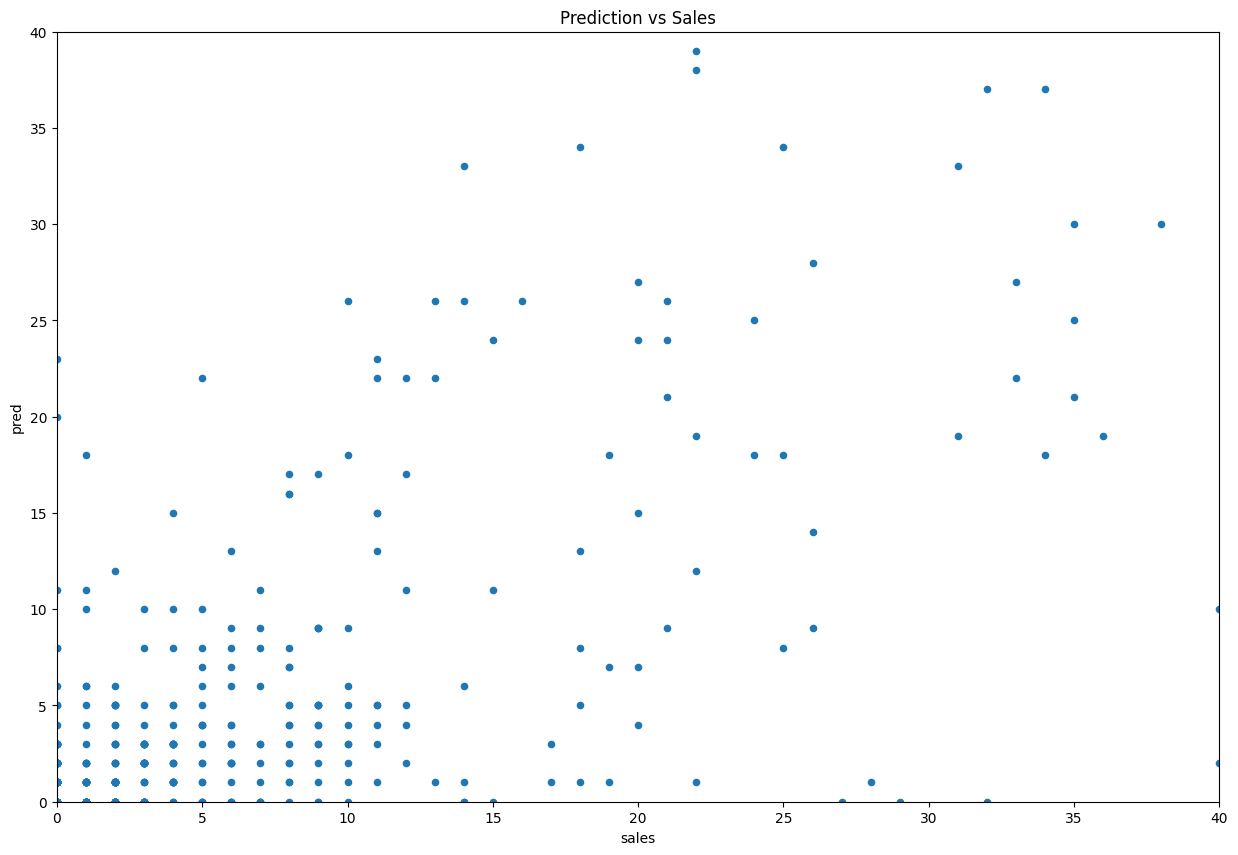

In [45]:
val.loc[:, 'pred'] = np.round(p)
val.plot.scatter(x='sales', y='pred', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,40), xlim=(0,40))